```
  __  __   _         __   _                        _______                         _      _                 
 |  \/  | | |       / _| | |                      |__   __|                       | |    (_)                
 | \  / | | |      | |_  | |   ___   __      __      | |     _ __    __ _    ___  | | __  _   _ __     __ _ 
 | |\/| | | |      |  _| | |  / _ \  \ \ /\ / /      | |    | '__|  / _` |  / __| | |/ / | | | '_ \   / _` |
 | |  | | | |____  | |   | | | (_) |  \ V  V /       | |    | |    | (_| | | (__  |   <  | | | | | | | (_| |
 |_|  |_| |______| |_|   |_|  \___/    \_/\_/        |_|    |_|     \__,_|  \___| |_|\_\ |_| |_| |_|  \__, |
                                                                                                       __/ |
                                                                                                      |___/ 
```

# Introduction

### MLflow is an open source platform for managing the end-to-end machine learning lifecycle. 

#### It tackles three primary functions:

    1) Tracking experiments to record and compare parameters and results (MLflow Tracking).
    2) Packaging ML code in a reusable, reproducible form in order to share with other data scientists or transfer to production (MLflow Projects).
    3) Managing and deploying models from a variety of ML libraries to a variety of model serving and inference platforms (MLflow Models).

(source https://www.mlflow.org/docs/latest/index.html#mlflow-documentation)

-------------------------------------------------------------------------------------------------------------------------------------------------------

### Here we demonstrate basic MLflow features:

    * logging parameters, metrics and artifacts in machine learning;
    * Mlflow UI usage to view and compare train models results.

### This notbooks constist of two parts:

    I. machine learning cycle: preprocess data, train, evaluate;
    II. logging to mlflow

# Part I.

In [2]:
%cd /home/mlflow-1-tracking/

/home/mlflow-1-tracking


In [3]:
import joblib
import itertools
import matplotlib.pyplot as plt
import mlflow
from mlflow import log_artifact, log_metric, log_param
from mlflow.tracking import MlflowClient
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

## Load dataset

In [4]:
dataset = pd.read_csv('data/raw/iris.csv')
dataset.shape

(150, 5)

In [5]:
dataset.head()

sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa

In [6]:
# feature names
feature_names = dataset.columns.tolist()[:4]
feature_names

['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

In [7]:
# iris species
species = dataset['species'].unique().tolist()
species

['setosa', 'versicolor', 'virginica']

## Features engineering

In [8]:
dataset['sepal_length_to_sepal_width'] = dataset['sepal_length'] / dataset['sepal_width']
dataset['petal_length_to_petal_width'] = dataset['petal_length'] / dataset['petal_width']

dataset = dataset[[
    'sepal_length', 'sepal_width', 'petal_length', 'petal_width',
    'sepal_length_to_sepal_width', 'petal_length_to_petal_width',
    'species'
]]

In [9]:
dataset.head()

sepal_length  sepal_width  petal_length  petal_width  \
0           5.1          3.5           1.4          0.2   
1           4.9          3.0           1.4          0.2   
2           4.7          3.2           1.3          0.2   
3           4.6          3.1           1.5          0.2   
4           5.0          3.6           1.4          0.2   

   sepal_length_to_sepal_width  petal_length_to_petal_width species  
0                     1.457143                          7.0  setosa  
1                     1.633333                          7.0  setosa  
2                     1.468750                          6.5  setosa  
3                     1.483871                          7.5  setosa  
4                     1.388889                          7.0  setosa

## Split dataset

In [10]:
test_size = 0.2

### transform targets (species) to numerics

In [11]:
dataset.loc[dataset.species=='setosa', 'species'] = 0
dataset.loc[dataset.species=='versicolor', 'species'] = 1
dataset.loc[dataset.species=='virginica', 'species'] = 2

### Split in train/test

In [12]:
train_dataset, test_dataset = train_test_split(dataset, test_size=test_size, random_state=42)
train_dataset.shape, test_dataset.shape

((120, 7), (30, 7))

## Train

In [13]:
train_config = {
    'cv': 5,
    'estimator_name': 'LogisticRegression',
    'estimators': {
        'LogisticRegression': {
            'param_grid': {
                'C': [0.001, 0.01],
                'max_iter': [100, 200, 300],
                'solver': ['lbfgs'],
                'multi_class': ['multinomial']}},
        'SVC': {
            'param_grid': {
                'C': [0.1, 1.0],
                'kernel': ['rbf', 'linear'],
                'gamma': ['scale'],
                'degree': [3, 5]
            }
        }
    }
}

estimators = {
        'LogisticRegression': LogisticRegression,
        'SVC': SVC
}

In [14]:
# Get X and y
X_train = train_dataset.drop('species', axis=1)
y_train = train_dataset.species

In [15]:
estimator_name = train_config['estimator_name']
estimator = estimators[estimator_name]()
f1_scorer = make_scorer(f1_score, average='weighted')
param_grid = train_config['estimators'][estimator_name]['param_grid']

clf = GridSearchCV(estimator=estimator,
                   param_grid=param_grid,
                   cv=train_config['cv'],
                   verbose=1,
                   scoring=f1_scorer,
                   iid=True)

clf.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.5s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid=True, n_jobs=None,
             param_grid={'C': [0.001, 0.01], 'max_iter': [100, 200, 300],
                         'multi_class': ['multinomial'], 'solver': ['lbfgs']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(f1_score, average=weighted), verbose=1)

In [16]:
clf.best_score_

0.87024409313883

## Evaluate

In [17]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [18]:
Xtest = test_dataset.drop('species', axis=1)
Ytest = test_dataset.species

In [19]:
y_pred = clf.predict(Xtest)

cm = confusion_matrix(y_pred, Ytest)
f1 = f1_score(y_true=Ytest, y_pred=y_pred, average='macro')

In [20]:
# f1 score value
f1

0.9305555555555555

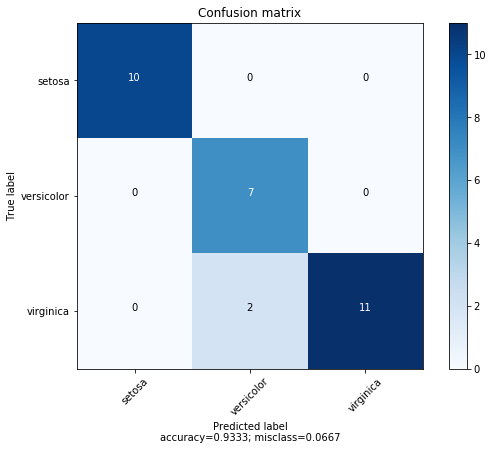

In [21]:
plot_confusion_matrix(cm, species, normalize=False)

## Persist model

In [22]:
joblib.dump(clf, 'models/model.joblib')

['models/model.joblib']

# Part II.

## Log into mlflow

In [23]:
'''
MlflowClient - Client of an MLflow Tracking Server that creates and manages experiments and runs.
source (https://www.mlflow.org/docs/latest/python_api/mlflow.tracking.html)
'''

client = MlflowClient()

'''
set experiment name;
new run will be created for this experiment;
if experiment does not exists then it will be created automatically;
'''
mlflow.set_experiment(estimator_name)

'''
start new run
'''

with mlflow.start_run() as run:

    print(run)
    print(run.info)
    print(run.info.run_uuid)
    
    '''
    Log parameters;
    
    absolutely all values what you need can be parameters;
    here we log all training parameters
    '''
    log_param(key='estimator', value=estimator_name)
    log_param(key='cv', value=train_config['cv'])
    for param, value in param_grid.items():
        log_param(key=param, value=value)
    
    '''
    Log metric;
    
    metrics are like parameters, but in UI they are located in separated column;
    '''
    log_metric(key='f1_score', value=f1)
    
    '''
    log artifacts;
    
    any file you specified can be artifact, for example, config, report or model;
    here we log trained model file
    '''
    log_artifact(local_path='models/model.joblib')

        

<ActiveRun: >
<RunInfo: artifact_uri='file:///home/mlflow-1-tracking/mlruns/0/1d1894c297ca45b9a99a2faeb89f9244/artifacts', end_time=None, experiment_id='0', lifecycle_stage='active', run_id='1d1894c297ca45b9a99a2faeb89f9244', run_uuid='1d1894c297ca45b9a99a2faeb89f9244', start_time=1561345760889, status='RUNNING', user_id='user'>
1d1894c297ca45b9a99a2faeb89f9244


# Enter MLflow ui
    
    MLflow ui allow to observe experiments and runs, to compare model by metrics and select best model params.
    
    
## http://0.0.0.0:5000

------------------------------------------------------------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------------------------------------------------------

# Concluion

    As you can see basic MLflow features are very simple, but very usefule.  You can log any parameters, metrics and artifacts. 
    It means that each you experiment can be captured.

-------------------------------------------------------------------------------------------------------------------------------

### ___Your task___

#### Train with another estimator

##### 1. Go to section __Train__
##### 2. In _train_config_ change _estimator_name_ to SVC
##### 3. Rerun stages __Train__,  __Evaluate__ and __Log into mlflow__
##### 4. Go to next section __Enter MLflow ui__

